Missing Values:
 CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
Summary Statistics:
         CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14064\1224404828.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Exited', data=data, palette=[LightBlue, Orange])


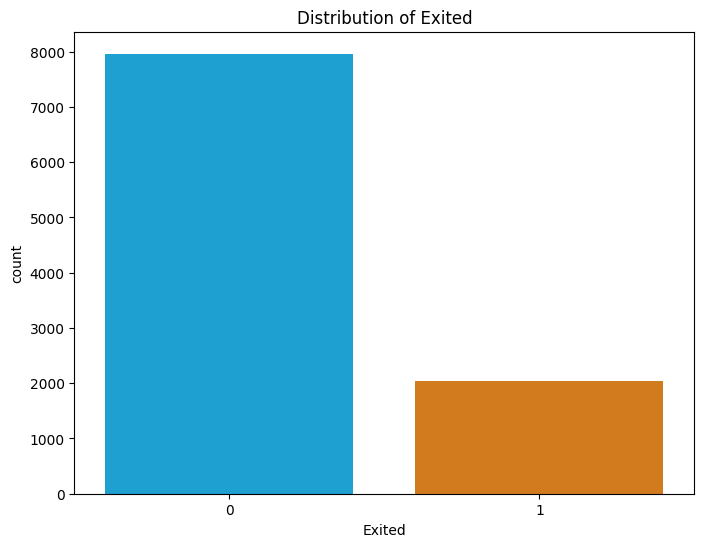

In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing and machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import shap

# Load Data
data = pd.read_csv('Churn_Modelling.csv')

# Remove irrelevant features
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Summary statistics
print("Summary Statistics:\n", data.describe())

# Define Colors for Visualization
DarkBlue = "#24477F"
LightBlue = "#00AEEF"
White = "#FFFFFF"
Black = "#000000"
MediumBlue = "#005EB8"
SkyBlue = "#7EC8E3"
Orange = "#EF7C00"

# Distribution of the target variable 'Exited'
plt.figure(figsize=(8, 6))
sns.countplot(x='Exited', data=data, palette=[LightBlue, Orange])
plt.title('Distribution of Exited')
plt.show()

In [3]:
# Feature Engineering
# data['Age_Balance'] = data['Age'] * data['Balance']
# data['CreditScore_NumOfProducts'] = data['CreditScore'] * data['NumOfProducts']
# data['HighBalance'] = (data['Balance'] > data['EstimatedSalary']).astype(int)
# data['Age_Bin'] = pd.cut(data['Age'], bins=[0, 30, 40, 50, 60, 100], labels=[1, 2, 3, 4, 5])

# Separate features and target variable
X = data.drop('Exited', axis=1)
y = data['Exited']

# Train-validation-test split
# 60% training, 20% validation, and 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Encode categorical variables
categorical_features = ['Geography', 'Gender']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# Create preprocessing pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

In [4]:
# Baseline model
rf_default = RandomForestClassifier(random_state=42)

# Train the baseline model on the training data
rf_default.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_default = rf_default.predict(X_val)

# Calculate and print validation accuracy
validation_accuracy = accuracy_score(y_val, y_val_pred_default)
print(f"Validation Accuracy with Baseline Random Forest: {validation_accuracy:.2f}")

# Optionally, print confusion matrix and classification report for more detailed evaluation
print("Validation Set Evaluation with Baseline Random Forest")
print(confusion_matrix(y_val, y_val_pred_default))
print(classification_report(y_val, y_val_pred_default))

Validation Accuracy with Baseline Random Forest: 0.86
Validation Set Evaluation with Baseline Random Forest
[[1561   59]
 [ 214  166]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1620
           1       0.74      0.44      0.55       380

    accuracy                           0.86      2000
   macro avg       0.81      0.70      0.73      2000
weighted avg       0.85      0.86      0.85      2000



In [5]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_default = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_default, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model after Grid Search
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate on validation set with best model
y_val_pred = best_model.predict(X_val)
print("Validation Set Evaluation with Best Model")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Validation Set Evaluation with Best Model
[[1568   52]
 [ 217  163]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1620
           1       0.76      0.43      0.55       380

    accuracy                           0.87      2000
   macro avg       0.82      0.70      0.73      2000
weighted avg       0.86      0.87      0.85      2000



In [6]:
# Apply Random Over-Sampling using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train and evaluate the best model with SMOTE
best_model.fit(X_train_smote, y_train_smote)
y_val_pred_smote = best_model.predict(X_val)
print("Validation Set Evaluation with SMOTE")
print(confusion_matrix(y_val, y_val_pred_smote))
print(classification_report(y_val, y_val_pred_smote))

# Evaluate on test set with best model (because we choose SMOTE as our final model based on its validation performance, so apply to test set)
y_test_pred_smote = best_model.predict(X_test)
print("Test Set Evaluation with Best Model")
print(confusion_matrix(y_test, y_test_pred_smote))
print(classification_report(y_test, y_test_pred_smote))

Validation Set Evaluation with SMOTE
[[1427  193]
 [ 150  230]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1620
           1       0.54      0.61      0.57       380

    accuracy                           0.83      2000
   macro avg       0.72      0.74      0.73      2000
weighted avg       0.84      0.83      0.83      2000

Test Set Evaluation with Best Model
[[1406  164]
 [ 162  268]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1570
           1       0.62      0.62      0.62       430

    accuracy                           0.84      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.84      0.84      0.84      2000



In [7]:
# Apply Random Under-Sampling using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Train and evaluate the best model with RandomUnderSampler
best_model.fit(X_train_rus, y_train_rus)
y_val_pred_rus = best_model.predict(X_val)
print("Validation Set Evaluation with RandomUnderSampler")
print(confusion_matrix(y_val, y_val_pred_rus))
print(classification_report(y_val, y_val_pred_rus))

Validation Set Evaluation with RandomUnderSampler
[[1281  339]
 [ 110  270]]
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1620
           1       0.44      0.71      0.55       380

    accuracy                           0.78      2000
   macro avg       0.68      0.75      0.70      2000
weighted avg       0.83      0.78      0.79      2000



In [8]:
# Balanced Random Forest model (BalancedRandomForestClassifier)
brf_classifier = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_classifier.fit(X_train, y_train)

# Predict on the validation set with Balanced Random Forest model
y_val_pred_brf = brf_classifier.predict(X_val)
print("Validation Set Evaluation with Balanced Random Forest")
print(confusion_matrix(y_val, y_val_pred_brf))
print(classification_report(y_val, y_val_pred_brf))

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. 

Validation Set Evaluation with Balanced Random Forest
[[1286  334]
 [ 113  267]]
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1620
           1       0.44      0.70      0.54       380

    accuracy                           0.78      2000
   macro avg       0.68      0.75      0.70      2000
weighted avg       0.83      0.78      0.79      2000



In [9]:
# SHAP for interpretability of the best model (assuming best_model is the best model here)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [10]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check SHAP values and feature matrix dimensions
print(f"shap_values.shape: {shap_values.shape}")
print(f"X_test.shape: {X_test.shape}")

shap_values.shape: (2000, 11, 2)
X_test.shape: (2000, 11)


In [11]:
# Extract SHAP values for the target class (e.g., class 1)
class_index = 1  # Choose the class of interest (e.g., 1 for positive class)
shap_values_class_1 = shap_values[:, :, class_index]

# Verify the shape after extraction
print(f"shap_values_class_1.shape: {shap_values_class_1.shape}")

shap_values_class_1.shape: (2000, 11)


In [12]:
# Ensure dimensions match for plotting
assert shap_values_class_1.shape == X_test.shape, (
    f"Mismatch between SHAP values dimensions ({shap_values_class_1.shape}) and X_test dimensions ({X_test.shape})"
)

In [13]:
# Local Interpretation for a single prediction (SHAP Force Plot)
instance_index = 0  # Index of the instance to interpret
shap.initjs()
shap.force_plot(
    explainer.expected_value[class_index],  # Expected value for class 1
    shap_values_class_1[instance_index, :],  # SHAP values for instance
    X_test[instance_index, :],  # Feature values for instance
    feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out()  # Feature names
)

In [14]:
# Global Interpretation (SHAP Summary Plot)
# Convert X_test to DataFrame for better readability
X_test_df = pd.DataFrame(X_test, columns=pipeline.named_steps['preprocessor'].get_feature_names_out())

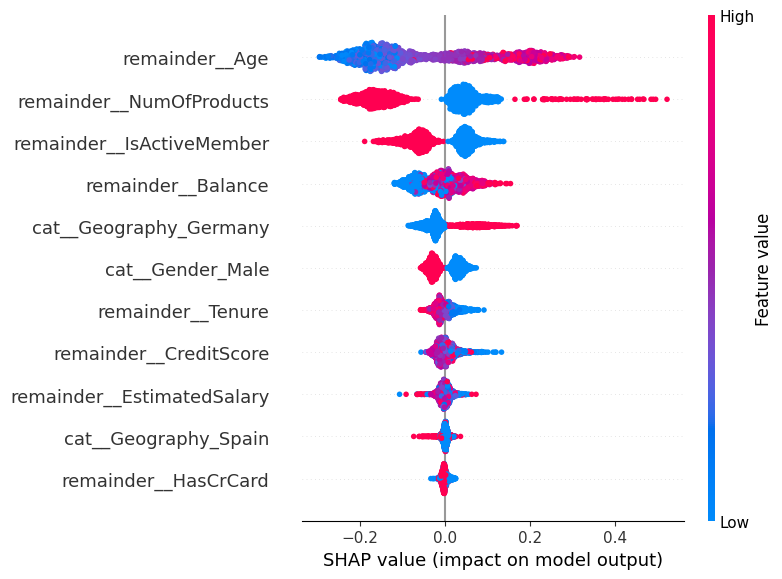

In [15]:
# Summary plot
shap.summary_plot(shap_values_class_1, X_test_df, feature_names=X_test_df.columns)

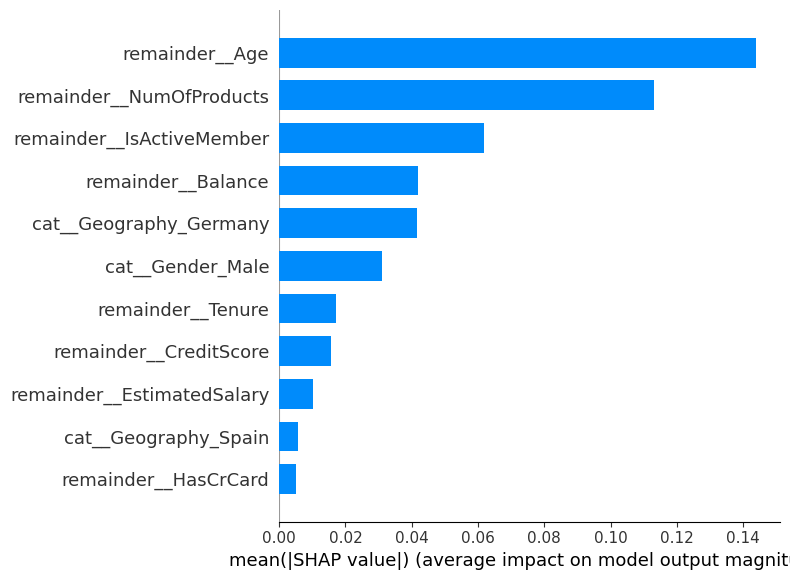

In [16]:
# Bar plot for feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class_1, X_test_df, plot_type="bar", feature_names=X_test_df.columns)